# Project 3: Clustering

## Business Understanding (10 points total).
• [10 points] Describe the purpose of the data set you selected (i.e., why was this data
collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?

## Data Understanding (20 points total)
• [10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems?

• [10 points] Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.

In [1]:
import pandas as pd
import numpy as np
import os
# import matplotlib.pyplot as plt
import warnings
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# path = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/DataMining/Classificaiton2/"
path = 'Z:/'
scada =  pd.read_csv(path + "SCADAcombined2017_T014.csv")
# scada2 = pd.read_csv(path + "SCADAcombined2017Q1")
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")


scada.dropna(thresh=10000,axis=1,inplace=True)

# colsdrop = ['StationId', 'CommunicationId', 'NeighbourId',
#            'NeighbourIdTwo', 'XPos', 'YPos', 'wtc_ActPower_min',
#            'wtc_ActPower_max', 'wtc_ActPower_stddev',
#            'wtc_AmpPhR_min', 'wtc_AmpPhR_max', 'wtc_AmpPhR_mean',
#            'wtc_AmpPhR_stddev', 'wtc_AmpPhS_min', 'wtc_AmpPhS_max',
#            'wtc_AmpPhS_mean', 'wtc_AmpPhS_stddev', 'wtc_AmpPhT_min',
#            'wtc_AmpPhT_max', 'wtc_AmpPhT_mean', 'wtc_AmpPhT_stddev',
#            'wtc_RawPower_min', 'wtc_RawPower_max', 'wtc_RawPower_mean',
#            'wtc_RawPower_stddev', 'wtc_GenRpm_mean',
#            'wtc_MainSRpm_mean', 'wtc_PitchRef_BladeA_mean',
#            'wtc_PitchRef_BladeB_mean', 'wtc_PitchRef_BladeC_mean','wtc_TwrHumid_mean', 
#             'wtc_PitcPosA_mean','wtc_PitcPosB_mean', 'wtc_PitcPosC_mean','wtc_BoostKWh_endvalue',
#            'wtc_GeOilTmp_mean','wtc_HubTemp_mean','wtc_NacelTmp_mean','wtc_ConvWTmp_mean',
#            'wtc_MainBTmp_mean','WindDir_Angle_3D_Avg','WindDir_Angle_3D_Std','WindDir_Angle_3D_Avg',
#            'WindDir_Angle_3D_Std']

#scada.drop(colsdrop,axis=1,inplace=True)


#################
# Merge data sets
#################
scada.dropna(inplace=True)
scada['wtc_AlarmCde_endvalue'] = scada['wtc_AlarmCde_endvalue'].astype(int)

df = scada.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)
######################
# Create new variables
######################

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

# Calculating Derate Conditions
derate = (df['PowerDelta'] < 0) & (df['Available'] == 1) & (df['BoostedRef'] < 2300) #df['BoostedRef'].max())
df['Derated'] = [1 if x == True else 0 for x in derate]

# Use cleaned data set for calculating expected energy
clean = (df['Available'] == 1) & (df['wtc_PowerRef_endvalue'] == 2300) & (df['Icing'] == 0) & (df['wtc_BoostAva_mean'] == 0)
df_clean = df[clean]

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:63: RuntimeWarning: divide by zero encountered in log


In [3]:
print("Dimensions of cleaned data frame: ", df_clean.shape)

df_clean.head()

Dimensions of cleaned data frame:  (17841, 704)


,StationId,wtc_VoltPhR_min,wtc_VoltPhR_max,wtc_VoltPhR_mean,wtc_VoltPhR_stddev,wtc_VoltPhS_min,wtc_VoltPhS_max,wtc_VoltPhS_mean,wtc_VoltPhS_stddev,wtc_VoltPhT_min,...,BoostedRef,WindSheer1,PowerDelta,Available,Icing,Air_density,AdjTurbineWS,TurbulenceMet,TurbulenceTurbine,Derated
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:10:00,2308974,398.2,401.2,399.2965,0.427948,397.8,401.0,399.6236,0.450038,399.2,...,2300.0,0.383947,1272.3540,1,0,1.167870,8.757056,0.086893,0.170941,0
2017-01-01 00:30:00,2308974,397.8,400.4,398.7805,0.315703,397.7,400.1,399.0097,0.317276,398.9,...,2300.0,0.457749,1485.1257,1,0,1.168782,7.924247,0.076817,0.097312,0
2017-01-01 00:40:00,2308974,398.1,400.5,399.1493,0.326358,397.8,400.2,399.4183,0.313926,399.1,...,2300.0,0.448346,1010.5090,1,0,1.167753,9.604117,0.118237,0.153926,0
2017-01-01 00:50:00,2308974,398.5,400.8,399.3499,0.267426,398.2,400.5,399.6837,0.247382,399.5,...,2300.0,0.470499,907.0890,1,0,1.167919,10.050963,0.083196,0.065130,0
2017-01-01 01:20:00,2308974,397.4,399.6,398.2397,0.314187,395.9,399.4,398.4738,0.297155,398.4,...,2300.0,0.485251,1674.3712,1,0,1.169846,7.109020,0.119338,0.152973,0


## Modeling and Evaluation (50 points total)
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results. Each option is broken down by:

• [10 Points] Train and adjust parameters

• [10 Points] Evaluate and Compare

• [10 Points] Visualize Results

• [20 Points] Summarize the Ramifications

### Option A: Cluster Analysis
• Train: Perform cluster analysis using several clustering methods (adjust parameters).

• Eval: Use internal and/or external validation measures to describe and compare the
clusterings and the clusters— how did you determine a suitable number of clusters for
each method?

• Visualize: Use tables/visualization to discuss the found results. Explain each
visualization in detail.

• Summarize: Describe your results. What findings are the most interesting and why?

### Train: Perform Custer Analysis Using Several Clustering methods and adjust parameters (10 points)

First, I want to look at wind speed vs historical power output. It will be interesting to see how different turbines are clustered together, especially if their name plate capacity is different across clusters.

## First I need to look at a graph of the two variables that I am attempting to cluster. I want to see if there are any obvious groups to adjust the number of clusters for KMeans and for adjustment of other parameters. 

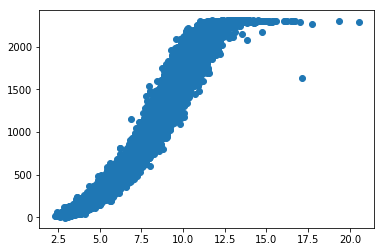

In [4]:
import matplotlib.pyplot as plt
wind = df_clean['wtc_AcWindSp_mean']
power = df_clean['wtc_ActPower_mean']


plt.scatter(wind, power)
plt.show()

No handles with labels found to put in legend.


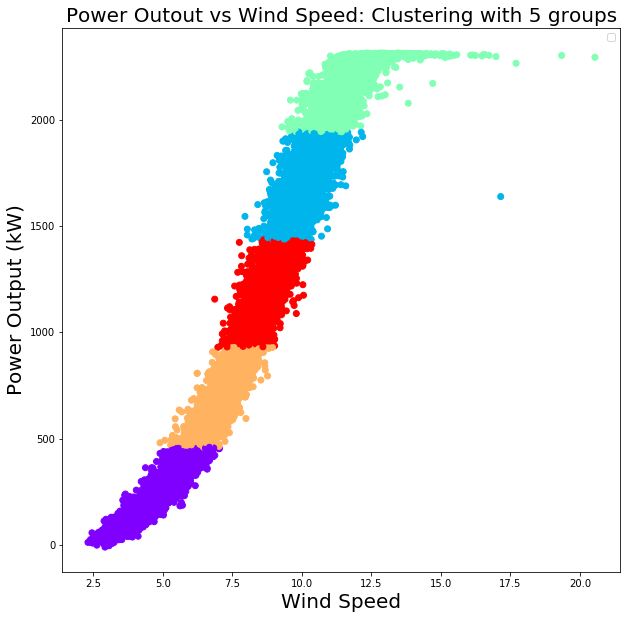

In [5]:
from sklearn.cluster import KMeans

n_clust = 5
X1 = df_clean[['wtc_AcWindSp_mean', 'wtc_ActPower_mean']]


cls_power_wind = KMeans(n_clusters= 5, init='k-means++', random_state=1)
cls_power_wind.fit(X1)
clust_labels  = cls_power_wind.labels_

X1 = X1.values
plt.figure(figsize=(10,10))
plt.scatter(X1[:,0], X1[:,1], c=clust_labels, cmap=plt.cm.rainbow)
plt.ylabel("Power Output (kW)", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Power Outout vs Wind Speed: Clustering with {} groups".format(n_clust), fontsize=20)
plt.show()


No handles with labels found to put in legend.


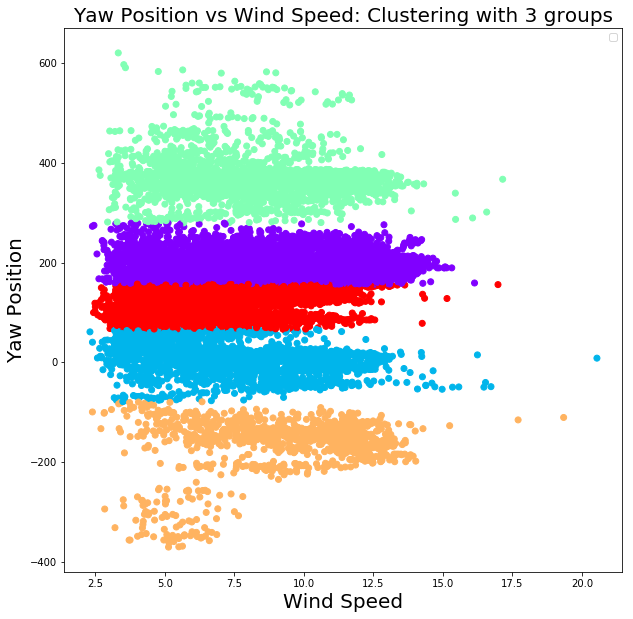

No handles with labels found to put in legend.


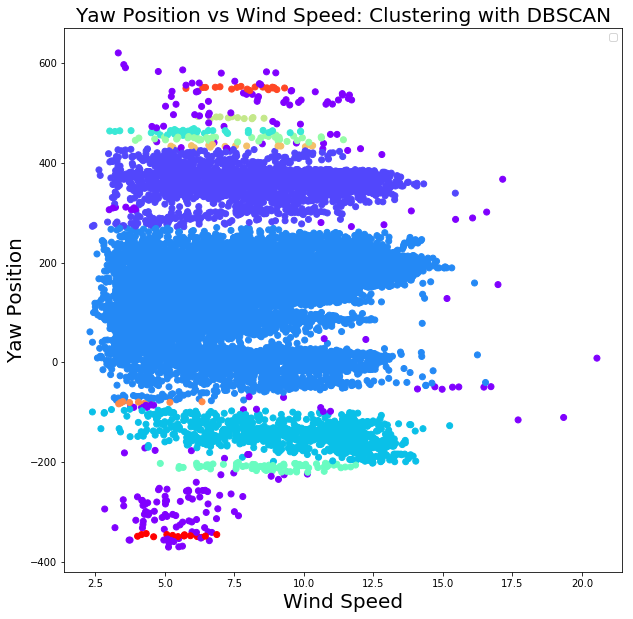

In [6]:
# Next I want to look at Yaw Position vs Wind Speed. 

from sklearn.cluster import DBSCAN

n_clust = 3
X2 = df_clean[['wtc_AcWindSp_mean', 'wtc_ScYawPos_mean']]

# K Means
cls_yaw_wind = KMeans(n_clusters= 5, init='k-means++', random_state=1)
cls_yaw_wind.fit(X2)
clust_labels_yaw  = cls_yaw_wind.labels_

# DB Scan
db_yaw_wind = DBSCAN(eps=3, min_samples=10)
db_yaw_wind.fit(X2)
db_labels_yaw = db_yaw_wind.labels_ 


X2 = X2.values
plt.figure(figsize=(10,10))
plt.scatter(X2[:,0], X2[:,1], c=clust_labels_yaw, cmap=plt.cm.rainbow)
plt.ylabel("Yaw Position", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Yaw Position vs Wind Speed: Clustering with {} groups".format(n_clust), fontsize=20)
plt.show()

print()
plt.figure(figsize=(10,10))
plt.scatter(X2[:,0], X2[:,1], c=db_labels_yaw, cmap=plt.cm.rainbow)
plt.ylabel("Yaw Position", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Yaw Position vs Wind Speed: Clustering with DBSCAN".format(n_clust), fontsize=20)
plt.show()




No handles with labels found to put in legend.


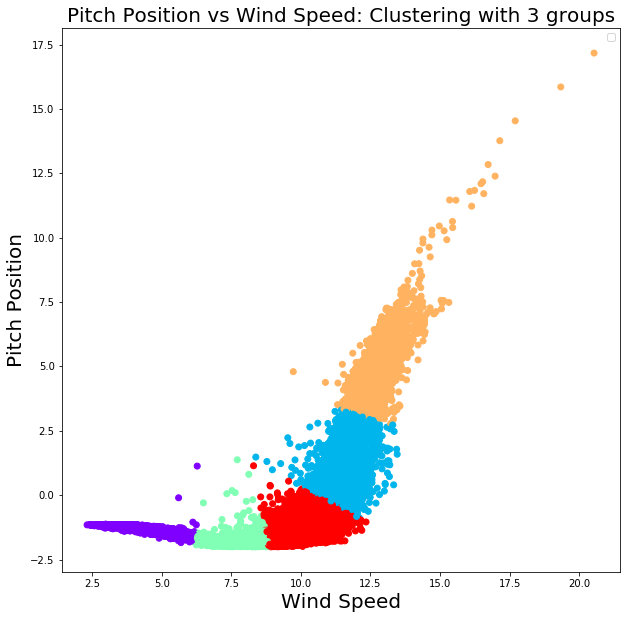

No handles with labels found to put in legend.


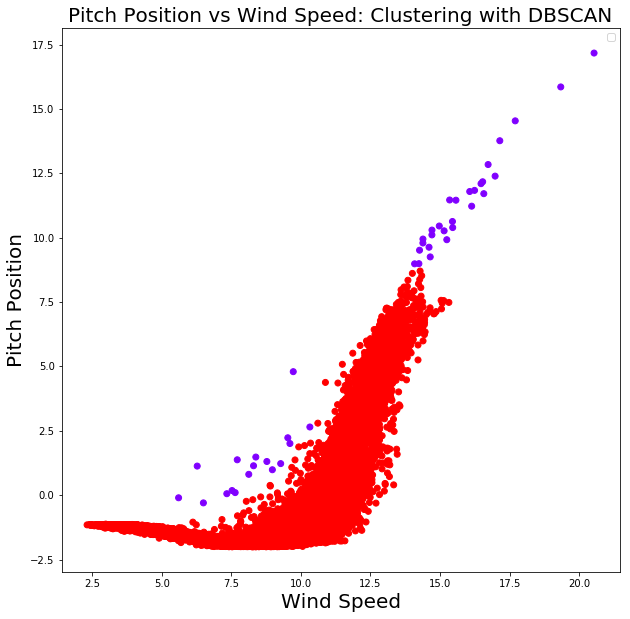

In [7]:
# Next I want to look at Pitch Position vs Wind Speed. 

from sklearn.cluster import DBSCAN
df_clean['wtc_PitcPosA_mean']

n_clust = 3
X3 = df_clean[['wtc_AcWindSp_mean', 'wtc_PitcPosA_mean']]

# K Means
cls_pitch_wind = KMeans(n_clusters= 5, init='k-means++', random_state=1)
cls_pitch_wind.fit(X3)
clust_labels_pitch  = cls_pitch_wind.labels_

# DB Scan
db_pitch_wind = DBSCAN(eps=0.5, min_samples=10)
db_pitch_wind.fit(X3)
db_labels_pitch = db_pitch_wind.labels_ 


X3 = X3.values
plt.figure(figsize=(10,10))
plt.scatter(X3[:,0], X3[:,1], c=clust_labels_pitch, cmap=plt.cm.rainbow)
plt.ylabel("Pitch Position", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Pitch Position vs Wind Speed: Clustering with {} groups".format(n_clust), fontsize=20)
plt.show()

print()
plt.figure(figsize=(10,10))
plt.scatter(X3[:,0], X3[:,1], c=db_labels_pitch, cmap=plt.cm.rainbow)
plt.ylabel("Pitch Position", fontsize=20)
plt.xlabel("Wind Speed", fontsize=20)
plt.axis('tight')
plt.legend()
plt.title("Pitch Position vs Wind Speed: Clustering with DBSCAN", fontsize=20)
plt.show()

## Deployment (10 points total)
• Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

• How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?

• How would your deploy your model for interested parties?

• What other data should be collected?

• How often would the model need to be updated, etc.?

## Exceptional Work (10 points total)
• You have free reign to provide additional analyses or combine analyses.